# Introduction

In this example we will work with multidimensional data. I will first create a dummy dataset, so you understand exactly what the data are and how they are shaped. Then we will convert this dummy dataset to NetCDF-CF.

# Import modules

Firstly, let's import the modules that we will use in this example

In [48]:
import xarray as xr # For creating a NetCDF dataset

import pandas as pd # For reading in data (CSV, xlsx etc) to a dataframe

from datetime import datetime as dt # Handling dates and times

import uuid # Creating a UUID for the dataset

import numpy as np # Good for working with multidimensional arrays and mathematical functions

from matplotlib import pyplot as plt # For plotting data

# Creating the data

Let's imagine we are interested in surface sea water temperatures recorded daily across a grid of longitudes and latitudes.   

In [49]:
time = np.arange(0,10,1)
latitude = np.arange(75,80,1)
longitude = np.arange(30,33,1)
time, latitude, longitude

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([75, 76, 77, 78, 79]),
 array([30, 31, 32]))

Now, let's create a multidimensional grid for our sea_surface_skin_temperature variable. Firstly, we will fill it with zeros. The shape of the grid will be determined by the length of all the other dimensions. 

In [50]:
sea_surface_skin_temperature = np.zeros([len(time), len(latitude), len(longitude)])

Now we can fill in the grid for each time in turn. We will use random numbers for simplicity, between 0 and 2 degrees.

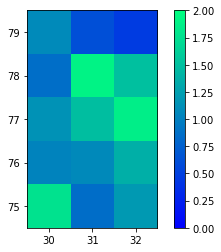

(10, 5, 3)

In [51]:
for t in time:
    sea_surface_skin_temperature[t, :, :] = np.random.uniform(0,2, size=(len(latitude), len(longitude)))

extent = [min(longitude)-0.5,max(longitude)+0.5,min(latitude)-0.5,max(latitude)+0.5]
plt.imshow(sea_surface_skin_temperature[6], vmin=0, vmax=2, cmap='winter', interpolation='nearest', extent=extent)
plt.colorbar()
plt.show()

sea_surface_skin_temperature.shape # Checking the shape is okay

Let's also imagine that a value was not recorded at certain points. I'll pick these at random, and assign a NAN using numpy. We will talk about how we handle these missing values later.

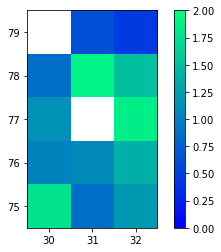

In [52]:
sea_surface_skin_temperature[6,2,1] = np.nan
sea_surface_skin_temperature[4,0,2] = np.nan
sea_surface_skin_temperature[6,0,0] = np.nan
sea_surface_skin_temperature[1,1,1] = np.nan

plt.imshow(sea_surface_skin_temperature[6], vmin=0, vmax=2, cmap='winter', interpolation='nearest', extent=extent)
plt.colorbar()
plt.show()

# Creating an xarray dataset

With xarray, it is easy to create an xarray dataset and convert it to a NetCDF dataset.

We have to consider what components make up a NetCDF file. It has dimensions (time, latitude, longitude) that define the shape, or grid, of the data. It also has variables (sea_surface_skin_temperature), that sit on each point in the grid. The *data_vars* in an xarray dataset are analagous to variables in a NetCDF file, whilst the *coords* are analagous to the dimensions. 

In [53]:
xrds = xr.Dataset(
    data_vars = dict(
        sea_surface_skin_temperature = (["time", "latitude", "longitude"], sea_surface_skin_temperature)
    ),
    coords = dict(
        longitude = longitude, # These coordinate names are compliant with CF conventions (all lower case)
        latitude = latitude, #
        time = time #
    )
)

xrds # Checking it looks okay

<xarray.Dataset>
Dimensions:                       (latitude: 5, longitude: 3, time: 10)
Coordinates:
  * longitude                     (longitude) int64 30 31 32
  * latitude                      (latitude) int64 75 76 77 78 79
  * time                          (time) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    sea_surface_skin_temperature  (time, latitude, longitude) float64 0.3274 ...

Let's also check that the values for the variable are in the right place before we proceed. The plot we create below should be identical to the one we create above. Make sure that you have not regenerated new random numbers at some point by running one of the cells again out of turn.

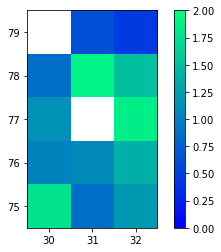

In [54]:
plt.imshow(xrds["sea_surface_skin_temperature"][6], vmin=0, vmax=2, cmap='winter', interpolation='nearest', extent=extent)
plt.colorbar()
plt.show()

# Global attributes

Global attributes describe the dataset as a whole. A list of what global attributes must be included can be found here:

https://adc.met.no/node/4

Additional global attributes can also be included, defined by the user. Make sure that the attribute names you select are understandable. In the Nansen Legacy project, we recommend also including the following global attributes are included as a minimum. 

* sampling_protocols: Cite the published Nansen Legacy sampling protocols. Remember to refer to a specific version and section within.
* depth_of_seabed_in_meters: Can be taken from the 'Bottom depth in meters' column in the metadata catalogue.
* metadata_link: DOI provided for the file by the data repository.
* metadata catalogue: https://sios-svalbard.org/aen/tools 

In this case, the entire dataset corresponds to a single event ID in the metadata catalogue (https://sios-svalbard.org/aen/tools). We must refer to this to link the dataset to the metadata catalogue, that includes some supplementary metadata that won't be included in the dataset.

The ID must be unique to this dataset, but also reproducible if you need to generate it again (e.g. if updating the dataset). We can use a version 5 UUID for this. There is a nice explanation here on what a version 5 UUID is: https://uuid.ramsey.dev/en/latest/rfc4122/version5.html

In [55]:
title = f'Sea surface skin temperature measurements from the Northern Barents Sea in July 2020'

ID = str(uuid.uuid5(uuid.NAMESPACE_URL,title))

xrds.attrs={
    'id': ID, # Note that this is the ID for the dataset, not the event ID in the metadata catalogue.
    'naming_authority': 'University Centre in Svalbard (UNIS)',
    'title': title,
    'summary': 'A long and descriptive abstract, analagous to an abstract in a journal article, that describes the data',
    # GCMD keywrods found here: https://gcmd.earthdata.nasa.gov/static/kms/. Separate with ; if multiple are used
    'keywords': 'Earth Science > Oceans > Ocean Temperature > Sea Surface Temperature > Sea Surface Skin Temperature',
    'keywords_vocabulary': 'GCMD',
    'geospatial_lat_min': min(latitude),
    'geospatial_lat_max': max(latitude),
    'geospatial_lon_min': min(longitude),
    'geospatial_lon_max': max(longitude),
    'time_coverage_start': '2020-07-10T12:00:00Z',
    'time_coverage_end': '2020-07-19T12:00:00Z',
    'Conventions': 'ACDD-1.3, , CF-1.8', # Check that version is correct
    'history': 'File created at '+dt.now().strftime("%Y-%m-%dT%H:%M:%SZ")+' using the xarray library in Python',
    'source': 'Sea surface temperature measurements recorded by....okay, I made them up!',
    'processing_level': 'raw',
    'date_created': dt.now().strftime("%Y-%m-%dT%H:%M:%SZ"),
    'creator_type': 'person; person',
    'creator_institution': 'The University Centre in Svalbard, Norway; The University Centre in Svalbard, Norway',
    'creator_name': 'Luke Marsden; John Doe',
    'creator_email': 'lukem@unis.no; jodoe@unis.no',
    'creator_url': 'https://www.unis.no/staff/luke-marsden/; https://www.unis.no/staff/john-doe/',
    'institution': 'The University Centre in Svalbard (UNIS)',
    'publisher_name': 'Norwegian Meteorological Institute - Arctic Data Centre',
    'publisher_email': 'adc-suppoort@met.no',
    'publisher_url': 'https://adc.met.no/',
    'publisher_type': 'institution',
    'project': 'The Nansen Legacy (RCN # 276730)',
    'license': 'https://creativecommons.org/licenses/by/4.0/',
    'metadata_link': '', # DOI provided by data repository
    'metadata_catalogue': 'https://sios-svalbard.org/aen/tools, event ID = a5ec89da-f45e-11eb-b6ae-0f3712703d75', # Dataset corresponds to single event ID in metadata catalogue
    'acknowledgements': 'Funded by the Research Council of Norway. John Smith was involved in collecting the data'
    }

# Variable attributes

Variable attributes describe each variable. Let's add some attributes for our variables.

The *standard_name* should be selected from here: http://cfconventions.org/standard-names.html. Standard names are commonly accepted parameter names with descriptions. By selecting appropriate standard names for your variable, the data user will be clear exactly what the data represent.

The *units* should match what is provided for the standard name as listed above. You may need to convert your data.

The *long_name* is more descriptive and can be in your own words.

The *coverage_content_type* describes what type of data the variable contains

Some help on these variable attributes can be found here: https://commons.esipfed.org/acdd_1-3_references

In [56]:
xrds['time'].attrs = {
'standard_name': 'time',
'long_name':'time',
'units': 'days since 2020-07-10T12:00:00Z'
}

xrds['latitude'].attrs = {
'standard_name': 'latitude',
'long_name':'decimal latitude in degrees north',
'units': 'degrees_north'
}

xrds['longitude'].attrs = {
'standard_name': 'longitude',
'long_name':'decimal longitude in degrees east',
'units': 'degrees_east'
}

xrds['sea_surface_skin_temperature'] += 273.15 # Converting from degrees celsius to kelvin

xrds['sea_surface_skin_temperature'].attrs = {
'standard_name':'sea_surface_skin_temperature',
'long_name':'Temperature of the sea water directly below the surface',
'units': 'K',
'coverage_content_type': 'physicalMeasurement'
}


Ensure that data are written in the correct form to NetCDF. 
Data served through THREDDS Data Servers cannot have int64 datetime 
specifications, but int32. Also, encoding of missing values are done 
in this step along compression.

# Converting to NetCDF-CF

First, we specify the encoding, then we conver the data to a NetCDF file. We will now add a fill value for the missing values we introduced earlier. This should be a nonesensical value. In this case, we will just make it really high.

In [57]:
myencoding = {
            'time': {
                'dtype': 'int32',
                '_FillValue': None # Coordinate variables should not have fill values.
                },
            'latitude': {
                'dtype': 'float32',
                '_FillValue': None # Coordinate variables should not have fill values.
                },
            'longitude': {
                'dtype': 'float32',
                '_FillValue': None # Coordinate variables should not have fill values.
                },
            'sea_surface_skin_temperature': {
                '_FillValue': -999,
                'zlib': False
                }
            }
        
xrds.to_netcdf(f'{title}.nc',encoding=myencoding)

And that is it! 

# QC the dataset

Now we can check that the file is okay by loading it in again.

In [58]:
myfile = xr.load_dataset(f'{title}.nc')

In [59]:
myfile

<xarray.Dataset>
Dimensions:                       (latitude: 5, longitude: 3, time: 10)
Coordinates:
  * longitude                     (longitude) float32 30.0 31.0 32.0
  * latitude                      (latitude) float32 75.0 76.0 77.0 78.0 79.0
  * time                          (time) datetime64[ns] 2020-07-10T12:00:00 ....
Data variables:
    sea_surface_skin_temperature  (time, latitude, longitude) float64 273.5 ....
Attributes: (12/32)
    id:                   554b5b10-8675-500c-9ecd-9b23998c0b74
    naming_authority:     University Centre in Svalbard (UNIS)
    title:                Sea surface skin temperature measurements from the ...
    summary:              A long and descriptive abstract, analagous to an ab...
    keywords:             Earth Science > Oceans > Ocean Temperature > Sea Su...
    keywords_vocabulary:  GCMD
    ...                   ...
    publisher_type:       institution
    project:              The Nansen Legacy (RCN # 276730)
    license:              https://creativecommons.org/licenses/by/4.0/
    metadata_link:        
    metadata_catalogue:   https://sios-svalbard.org/aen/tools, event ID = a5e...
    acknowledgements:     Funded by the Research Council of Norway. John Smit...

In [60]:
myfile.attrs

{'id': '554b5b10-8675-500c-9ecd-9b23998c0b74',
 'naming_authority': 'University Centre in Svalbard (UNIS)',
 'title': 'Sea surface skin temperature measurements from the Northern Barents Sea in July 2020',
 'summary': 'A long and descriptive abstract, analagous to an abstract in a journal article, that describes the data',
 'keywords': 'Earth Science > Oceans > Ocean Temperature > Sea Surface Temperature > Sea Surface Skin Temperature',
 'keywords_vocabulary': 'GCMD',
 'geospatial_lat_min': 75,
 'geospatial_lat_max': 79,
 'geospatial_lon_min': 30,
 'geospatial_lon_max': 32,
 'time_coverage_start': '2020-07-10T12:00:00Z',
 'time_coverage_end': '2020-07-19T12:00:00Z',
 'Conventions': 'ACDD-1.3, , CF-1.8',
 'history': 'File created at 2021-08-04T11:41:41Z using the xarray library in Python',
 'source': 'Sea surface temperature measurements recorded by....okay, I made them up!',
 'processing_level': 'raw',
 'date_created': '2021-08-04T11:41:41Z',
 'creator_type': 'person; person',
 'creato

In [61]:
myfile.data_vars

Data variables:
    sea_surface_skin_temperature  (time, latitude, longitude) float64 273.5 ....

In [62]:
myfile['time']

<xarray.DataArray 'time' (time: 10)>
array(['2020-07-10T12:00:00.000000000', '2020-07-11T12:00:00.000000000',
       '2020-07-12T12:00:00.000000000', '2020-07-13T12:00:00.000000000',
       '2020-07-14T12:00:00.000000000', '2020-07-15T12:00:00.000000000',
       '2020-07-16T12:00:00.000000000', '2020-07-17T12:00:00.000000000',
       '2020-07-18T12:00:00.000000000', '2020-07-19T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-07-10T12:00:00 ... 2020-07-19T12:00:00
Attributes:
    standard_name:  time
    long_name:      time

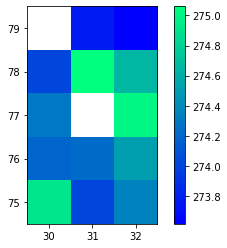

In [63]:
plt.imshow(myfile["sea_surface_skin_temperature"][6], cmap='winter', interpolation='nearest', extent=extent)
plt.colorbar()
plt.show()

The missing values were assigned a fill value when we wrote the netcdf file. However, because we specified the fill value as a variable attribute, xarray has automatically detected it for us and replaced it with a nan!